In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import tensorflow as tf
import cv2
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, sys

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

> Directory setting

In [2]:
mother_dir = "/kaggle/input/medsam-open-dataset-with-validation-set"

cxr_dir = '/kaggle/input/medsam-open-dataset-with-validation-set/NIH_CXR_TFREC/data'
mr_mother_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR"

endo_chole_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/CholecSeg8k/CholecSeg8k"
endo_kvasir_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/Kvasir-SEG/Kvasir-SEG"

mr_totalseg_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/MR_totalseg_mr/totalseg_mr"
mammo_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/Mammography/Mammography/CDD-CESM"
##########################
validation_image_dir = '/kaggle/input/medsam-open-dataset-with-validation-set/imgs/imgs'
validation_gt_dir = "/kaggle/input/medsam-open-dataset-with-validation-set/gts"

In [3]:
mri_dir = [os.path.join(mr_mother_dir, path) for path in os.listdir(mr_mother_dir)]
mri_dir = mri_dir + [mr_totalseg_dir]

# Exploring NPZ file format
- MR 등 multi frame: [n_of_frame, H, W]
- single frame data : [H,W,3] 등

> npz file을 load, imgs 키에 이미지 텐서가 있음

In [4]:
def get_image_from_npz(npz_file):
    return tf.convert_to_tensor(np.load(npz_file)["imgs"])
    
def merge_tensor(dirs, res = 384, shuffle = True):
    output = []
    for d in tqdm(dirs):
        # [N, H, W] or [H,W,3]
        tensor = get_image_from_npz(d)
        if tensor.shape[-1] != 3:
            tensor = tensor[..., tf.newaxis]
            tensor = tf.image.grayscale_to_rgb(tensor)
        # now tensor shape : [N. H, W, 3] or [H, W, 3]
        tensor = tf.image.resize_with_pad(
                                            tensor,
                                            res,
                                            res,
                                            antialias=True
                                        )
        tensor = tf.cast(tensor, "uint8")
        output.append(tensor) ; del tensor
    output = tf.concat(output, axis = 0)
    if shuffle:
        output = tf.random.shuffle(output)
    return output

100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


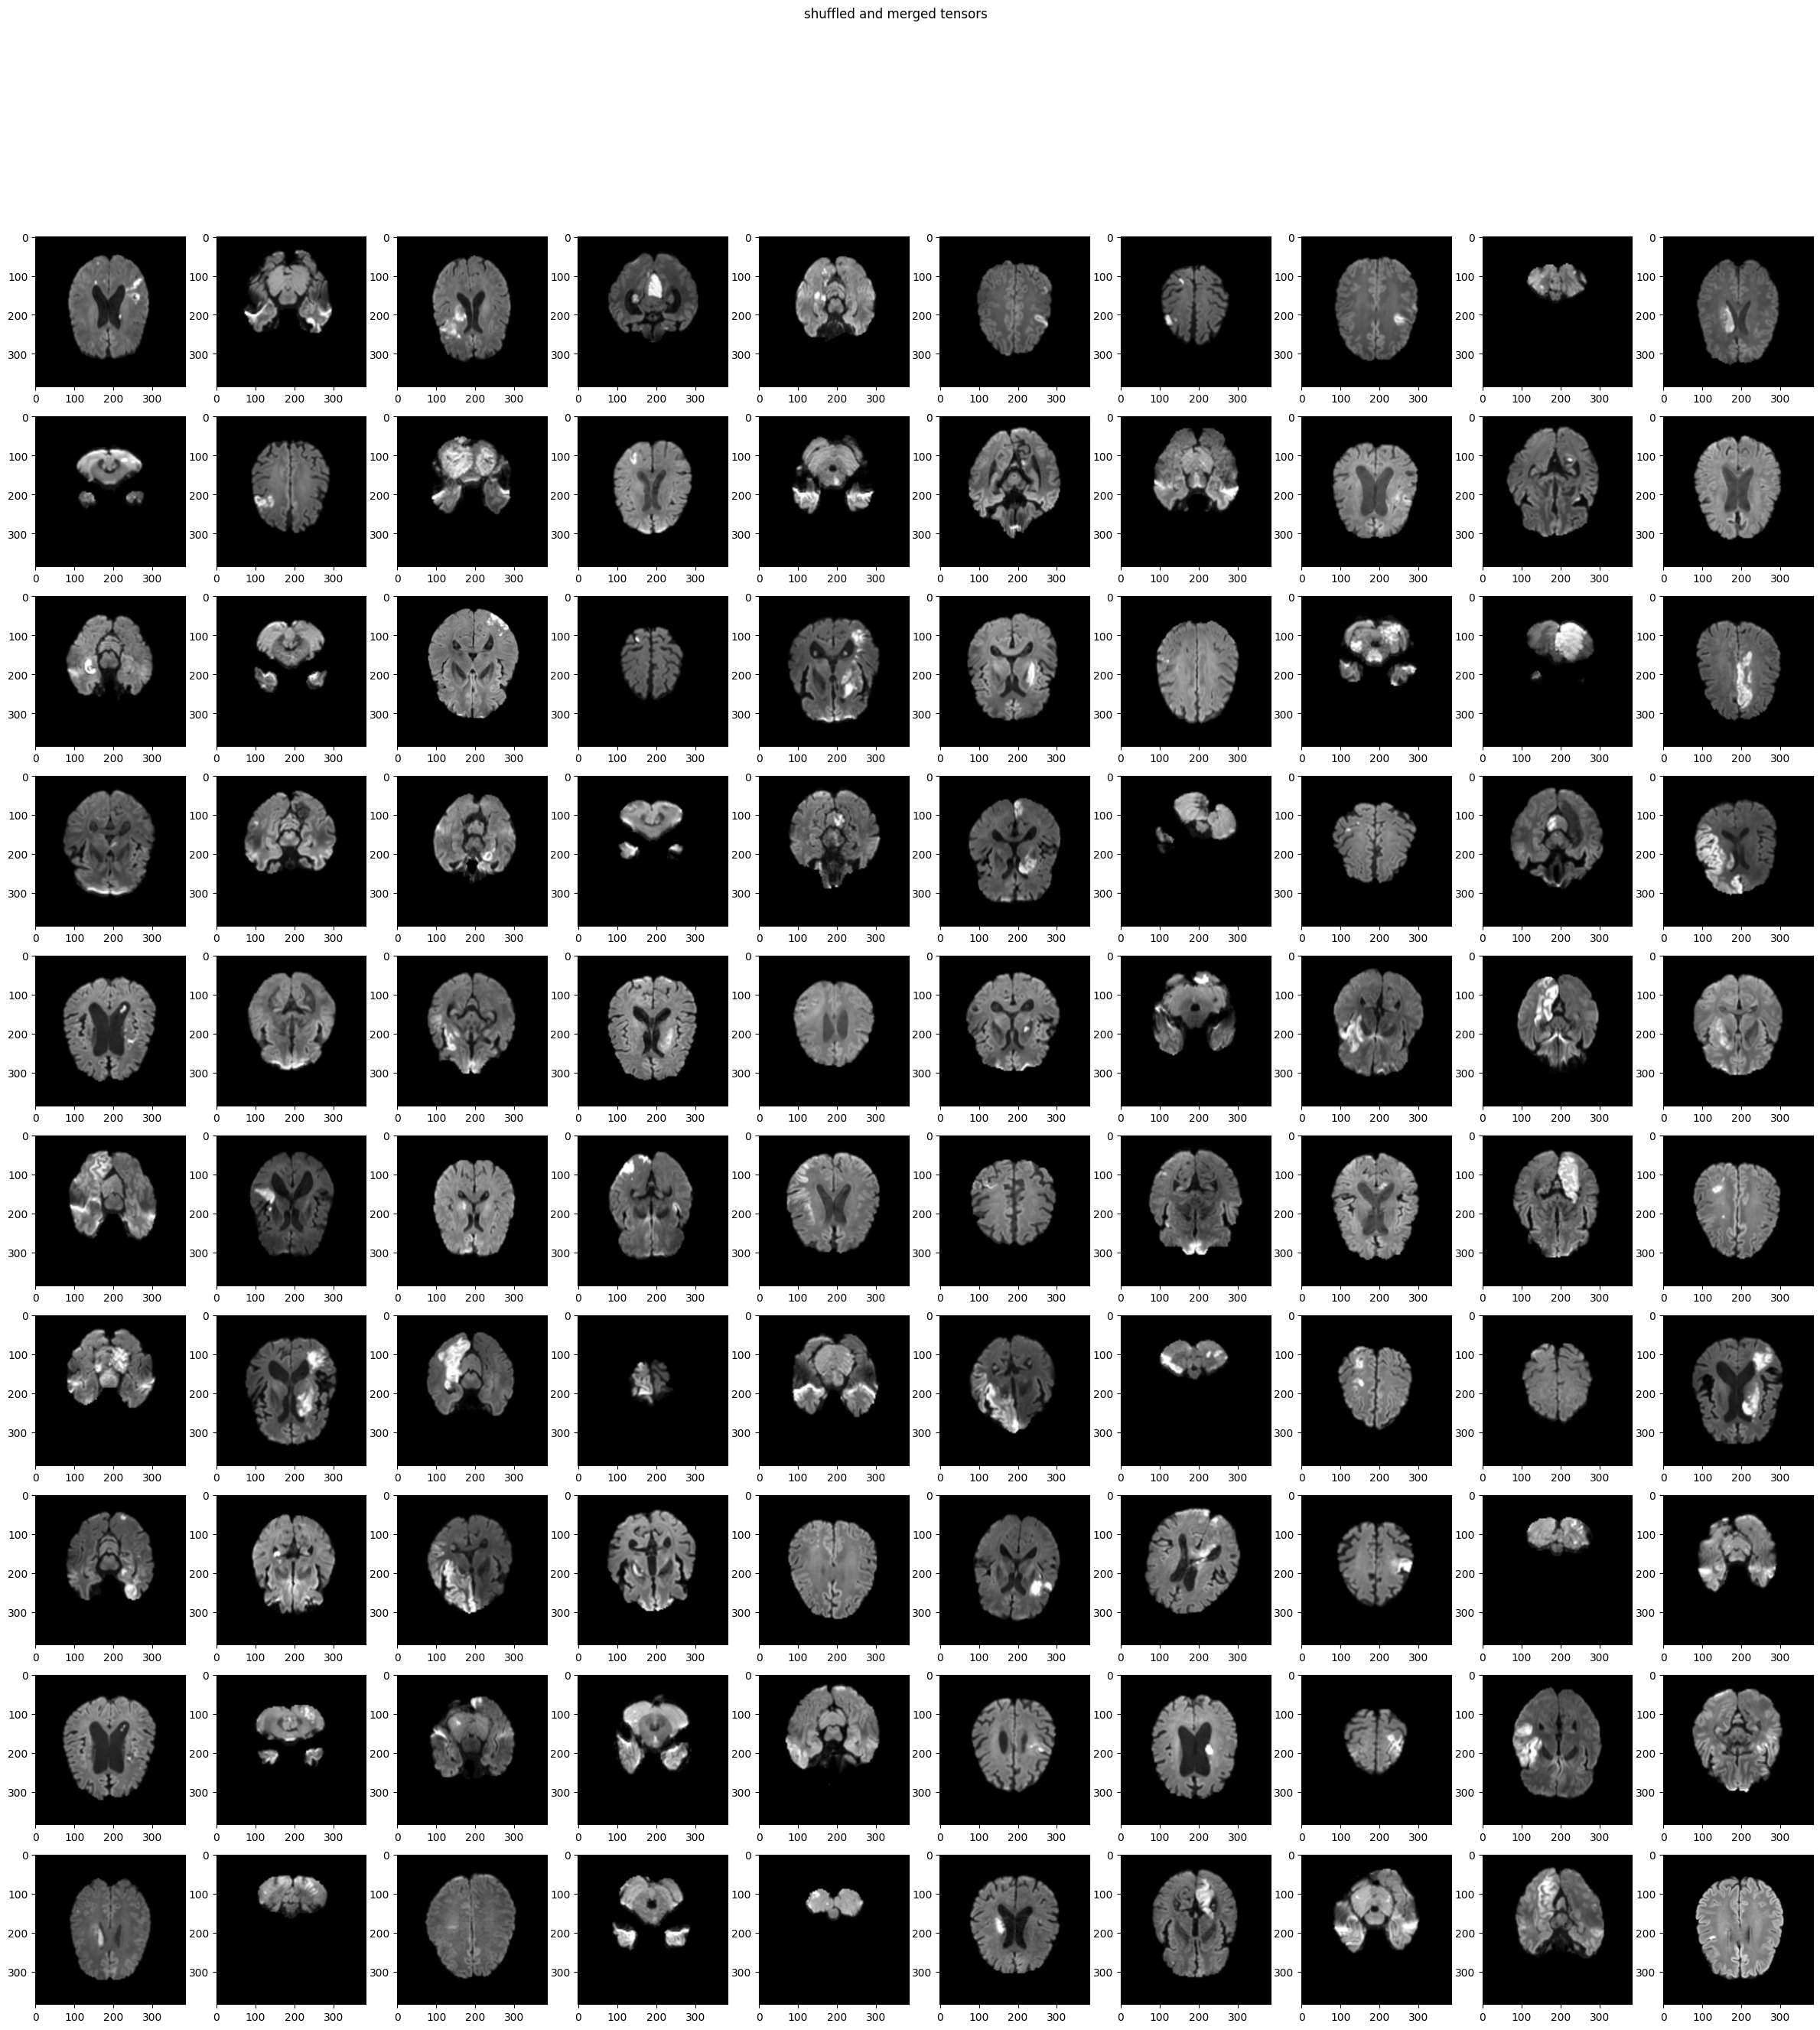

In [5]:
mr_dir_ = '/kaggle/input/medsam-open-dataset-with-validation-set/MR/MR/ISLES2022_DWI'
mr_files_ = [os.path.join(mr_dir_, d) for d in tqdm(os.listdir(mr_dir_))][:100]
tensors_ = tf.random.shuffle(merge_tensor(mr_files_))
fig, axes = plt.subplots(10, 10, figsize = (30,30))
axes = axes.flatten()
for t, ax in zip(tensors_, axes):
    ax.imshow(t)
plt.suptitle("shuffled and merged tensors")
plt.show()

# image (and bounding box) visualization

In [6]:
def visualize_image(img, bbox=None, label=None, figsize=(10, 8)):
  """
  이미지와 바운딩 박스를 시각화하는 함수

  Args:
    img: 이미지 텐서, shape은 [h, w, channel]
    bbox: 바운딩 박스 텐서, shape은 [number_of_boxes, 4] 또는 [number_of_boxes, 5]
    label: (Optional) 클래스 라벨
    figsize: 출력 이미지 크기

  Returns:
    None
  """

  # 이미지 출력 준비
  plt.figure(figsize=figsize)
  plt.imshow(img, cmap='gray' if img.shape[-1] == 1 else 'brg')  # 채널에 따라 컬러맵 조정

  # bbox가 존재할 경우에만 바운딩 박스 표시
  if bbox is not None:
    # 색깔 팔레트 생성
    colors = matplotlib.colormaps.get_cmap('hsv')

    # 바운딩 박스 표시
    for i in range(len(bbox)):
      box = bbox[i]
      xmin, ymin, xmax, ymax = box[:4]
      color = colors(i)

      # 바운딩 박스 그리기
      rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=2)
      plt.gca().add_patch(rect)

      # 라벨 표시 (선택적)
      if label is not None:
        plt.text(xmin, ymin - 2, f'{label[i]}', fontsize=12, color='white', bbox=dict(facecolor=color, alpha=0.5))

  plt.show()